# Forecasting Model

### Problem Description

Lets consider the following dataset taken from https://alrayon.carto.com/tables/scms_delivery_history_dataset_20150929/public/map in this data set we will try to predict the delay in delivery.

### Loading basic libraries

In [1]:
import numpy as np
import pandas as pd,re
import matplotlib.pyplot as plt
import scipy as sc
from datetime import timedelta
from sklearn.ensemble import forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import graphviz
from sklearn.tree import export_graphviz


from IPython.display import display
from pandas.plotting import bootstrap_plot,lag_plot
import seaborn as sns
plt.style.use('fivethirtyeight')

from scipy.cluster import hierarchy as hc

from pdpbox import pdp

import shap,treeinterpreter 

# Model imports
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
data = pd.read_csv('SCMS_Delivery_History_Dataset_20150929.csv',encoding='latin-1',parse_dates=["Scheduled Delivery Date","Delivered to Client Date","Delivery Recorded Date","PO Sent to Vendor Date","PQ First Sent to Client Date"],index_col=["ID"])

### PreProcessing and Data Cleaning

Here we will try to optimize the delay in delivery of the product,in order to find this we will create a variable to quantify it

In [3]:
data["Delay_in_delivery"] = data["Scheduled Delivery Date"]-data["Delivered to Client Date"]
data["Delay_in_delivery"] = data["Delay_in_delivery"].dt.days

Let's split data into training and test set

In [4]:
data_train=data.sample(frac=0.8,random_state=20)
data_test=data.drop(data_train.index)

Negative numbers indicate delivery before schedule and possitive vice versa.
Now we can look at the sampling distribution

In [5]:
data_train["Delay_in_delivery"].describe()

count    8259.000000
mean        5.946967
std        26.544759
min      -165.000000
25%         0.000000
50%         0.000000
75%         3.000000
max       372.000000
Name: Delay_in_delivery, dtype: float64

8259

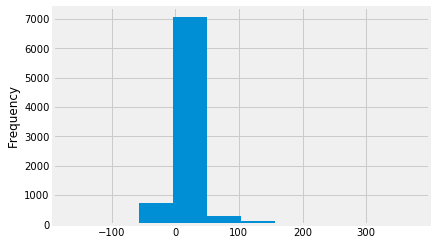

In [6]:
data_train["Delay_in_delivery"].plot.hist()
len(data_train)

3184

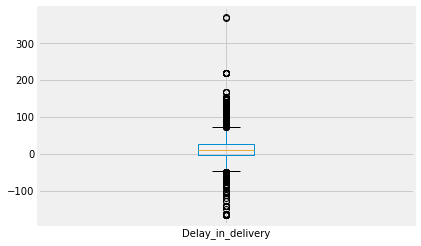

In [7]:
d=data_train[data_train["Delay_in_delivery"]!= 0]
d["Delay_in_delivery"].plot.box()
len(d)

In [8]:
print(f"number of on time delivery is",data_train[data_train["Delay_in_delivery"] <= 0].Delay_in_delivery.count())

number of on time delivery is 6007


So here we have 2246 deliveries that were delayed.We are interested in finding what factors in the dataset contributes most to these delays.So,lets start out by building a basic forest model and look at factors that contribute to this delay

date is an important factor in most cases.ie- whether it was raining on a certain day,or it was a holiday season that might have led to increased demands that led to delayed delivery ,etc.so in order to build it we will split all parsed dates in pandas date datatype and add it to our dataframe

first lets create new variables PO Sent to Vendor Date and PQ First Sent to Client Date where it's equal to Pre-PQ Process or Date Not Captured.We need to do this in order to parse them as dates

In [9]:
data_train['PO Sent to Vendor Date_Date Not Captured'] = data_train['PO Sent to Vendor Date'].apply(lambda x: 'True' if x == 'Date Not Captured' else 'False')
data_train['PQ First Sent to Client Date_Pre-PQ Process'] = data_train['PQ First Sent to Client Date'].apply(lambda x: 'True' if x == 'Pre-PQ Process' else 'False')
data_train['PQ First Sent to Client Date_Date Not Captured'] = data_train['PQ First Sent to Client Date'].apply(lambda x: 'True' if x == 'Date Not Captured' else 'False')

In [10]:
dates = ["Scheduled Delivery Date","Delivered to Client Date",'Delivery Recorded Date','PO Sent to Vendor Date','PQ First Sent to Client Date']
for x in dates:
    data_train[x]=pd.to_datetime(data_train[x], infer_datetime_format=True, errors='coerce')
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 
            'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    for n in attr: 
        data_train[re.sub('[Dd]ate$', '', x) + n] = getattr(data_train[x].dt, n.lower())
    data_train[re.sub('[Dd]ate$', '', x) + 'Elapsed'] = data_train[x].astype(np.int64) // 10 ** 9
    data_train.drop(x, axis=1, inplace=True)

Let's check the null values of data points

In [11]:
# with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
#         display((data_train.isnull().sum().sort_index()/len(data)))

In [12]:
# with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
#     display(data_train.apply(pd.Series.nunique))

now let's convert string values to categorical variables.

In [13]:
for i,c in data_train.items():
    if pd.api.types.is_string_dtype(c) and c.nunique()<=8: data_train[i] = c.astype('category').cat.as_ordered()

Let's look at the distribution of unique values in the integer columns

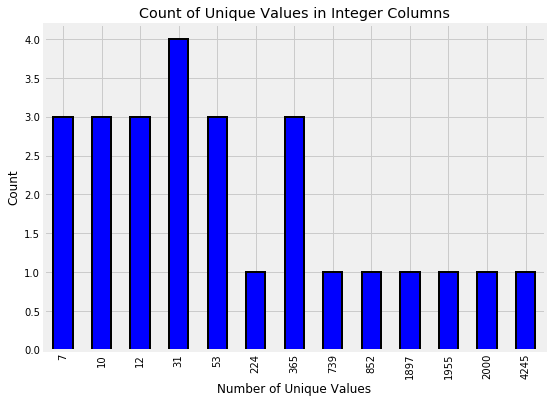

In [14]:
data_train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', figsize = (8, 6),
                                                                                  edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

Lets look af float values of different columns

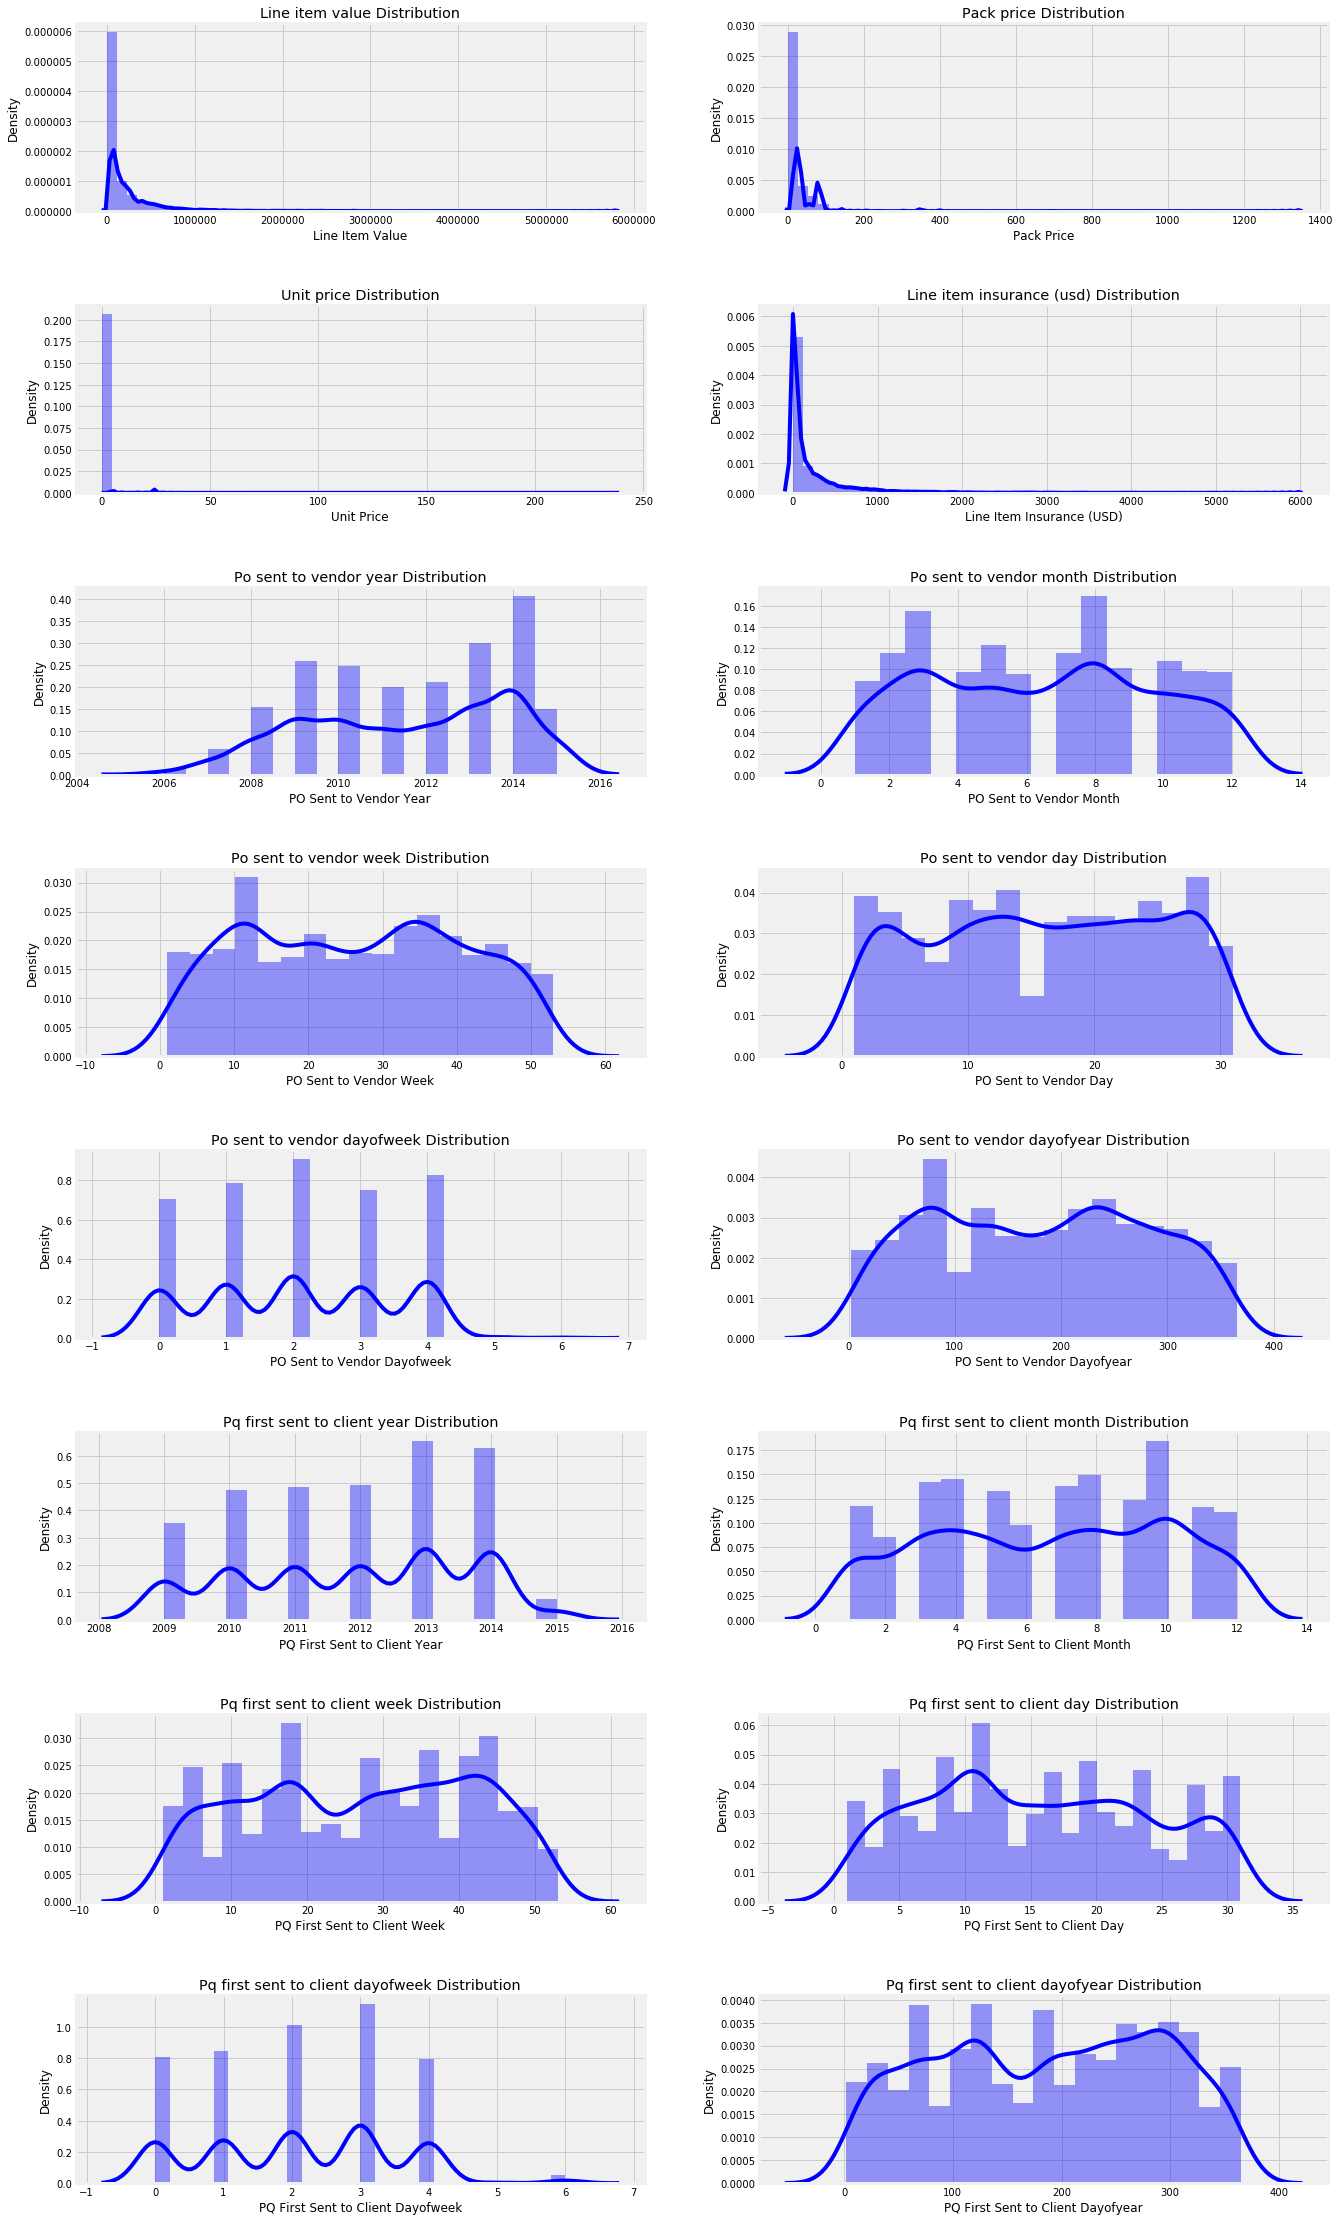

In [15]:
plt.figure(figsize = (20, 16))

for i, col in enumerate(data_train.select_dtypes('float')):
    ax = plt.subplot(8, 2, i + 1)
    sns.distplot(data_train[col].dropna(), ax = ax, color = 'blue')    
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
plt.subplots_adjust(top = 2, hspace=.5 )

we can use this later for comaparison

In [16]:
y_train = data_train["Delay_in_delivery"].values
df_train = data_train.copy()
df_train.drop("Delay_in_delivery", axis=1, inplace=True)

# replacing nan with median and creating new columns 
for n,c in df_train.items():
        na_dict = {}
        if pd.api.types.is_numeric_dtype(c):
            if pd.isnull(c).sum():
                df_train[n+'_na'] = pd.isnull(c)
                val = na_dict[n] if n in na_dict else c.median()
                df_train[n] = c.fillna(val)
                na_dict[n] = val

#adding categorical variables                
for n,c in df_train.items():
     if not pd.api.types.is_numeric_dtype(c):
        df_train[n] = pd.Categorical(c).codes+1 

#encoding variables        
df_train = pd.get_dummies(df_train, dummy_na=True)

### Base Model

In [17]:
m = RandomForestRegressor(n_estimators=10,n_jobs=-1)
m.fit(df_train, y_train)
m.score(df_train,y_train)

0.9619331213365526

Spliting data between a validation set,a training set and raw set.(it is important to have a good validation set)

In [18]:
n_valid = 300
n_train = len(df_train)-n_valid

In [19]:
def splitdata(a,n): return a[:n], a[n:]
X_train, X_valid = splitdata(df_train, n_train)
y_train, y_valid = splitdata(y_train, n_train)
raw_train, raw_valid = splitdata(data_train, n_train)

Let's add evaluation metrics (RMSE and R-squared)

In [20]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def score(m):
    result = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),m.score(X_train, y_train),
              m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

Evaluating a single tree model on the dataset

In [21]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
score(m)

[22.632193953317696, 20.19886474983222, 0.27328644791097023, 0.4137874893814298]


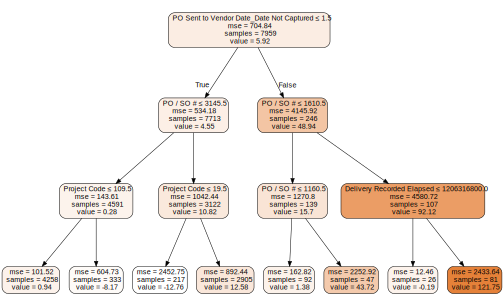

In [22]:
s=export_graphviz(m.estimators_[0], out_file=None, feature_names=df_train.columns, filled=True, 
                  special_characters=True, rounded=True, precision=2)
display(graphviz.Source(re.sub('Tree {',f'Tree {{ size=7; ratio=0.6', s)))

In [23]:
m = RandomForestRegressor(n_estimators=40, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
score(m)

[0.0, 12.58501208448632, 1.0, 0.7724334454848056]


Increasing the estimators made it much worse,lets try plot individual predictors

In [24]:
predictors = np.stack([t.predict(X_valid) for t in m.estimators_])

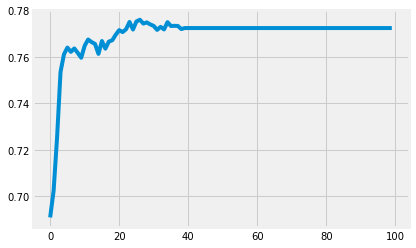

In [25]:
plt.plot([r2_score(y_valid, np.mean(predictors[:i+1], axis=0)) for i in range(100)]);

increasing the number of estimators wouldn't help much,lets check the oob score 

In [26]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
score(m)

[4.8668875900360575, 9.368330071754162, 0.9663943285107577, 0.8738969683182068, 0.7725383148387375]


Here we have RMSE for Training set,RMSE for Valid set,R-squared for training set,R-squared for valid set and OOB score.It seems the validation score difference affects our models overfitting.

lets look into tree depth

In [27]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, oob_score=True)
m.fit(X_train, y_train)
score(m)

[7.76446828052075, 9.649358275394007, 0.9144670626227491, 0.8662178953611224, 0.7645333684072255]


In [28]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
m.fit(X_train, y_train)
score(m)

[8.103189174939256, 9.652397314587857, 0.9068416253898703, 0.8661336134696765, 0.7604367116619607]


let's subsample the data for predicting <b>confidence interval</b>

In [29]:
forest._generate_sample_indices = (lambda rs, n_samples:
                                       forest.check_random_state(rs)
                                       .randint(0, n_samples, 4000))

In [30]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3 ,max_features=0.5, oob_score=True , n_jobs=-1)
m.fit(X_train, y_train)
score(m)

[10.198669708112169, 10.470691078471289, 0.8524303658052691, 0.8424741421095645, 0.7402310165976598]


### Permutation Importance

lets look at the feature importance of each column

In [31]:
f_imp =  pd.DataFrame({'feats':df_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
f_imp[:10]

,cols,imp
2,PO / SO #,0.095338
42,Scheduled Delivery Elapsed,0.081531
27,PO Sent to Vendor Date_Date Not Captured,0.059802
3,ASN/DN #,0.049629
1,PQ #,0.048544
0,Project Code,0.046250
55,Delivered to Client Elapsed,0.043969
68,Delivery Recorded Elapsed,0.042309
48,Delivered to Client Dayofyear,0.041392
32,Scheduled Delivery Week,0.035922


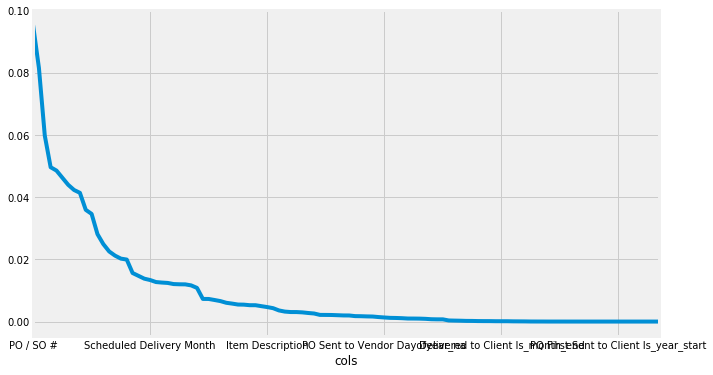

In [32]:
f_imp.plot('feats', 'imp', figsize=(10,6), legend=False);

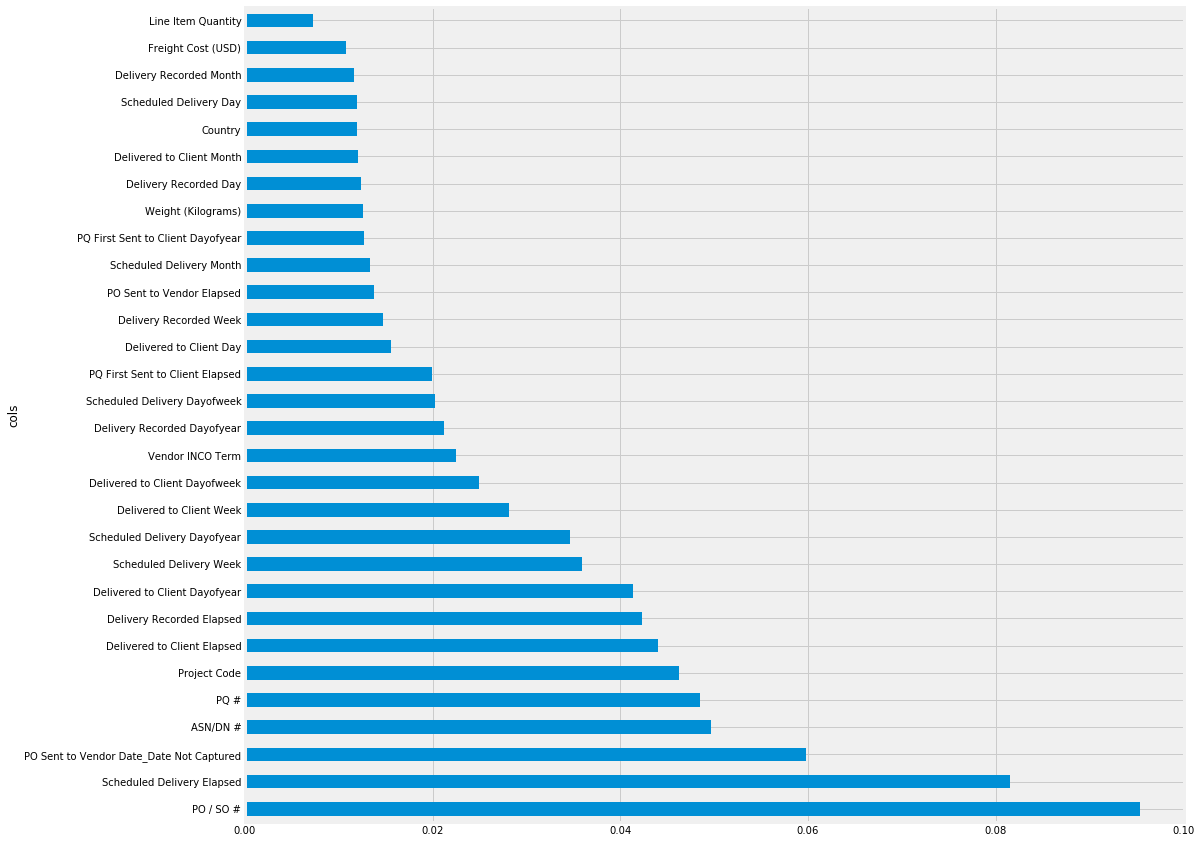

In [33]:
f_imp[:30].plot('feats', 'imp', 'barh', figsize=(15,15), legend=False)

at this point we generally sit down with client and discuss about the importance which may be the cause of data leak

lets remove features with little significance (feature importance<0.005) as the graph seems flat in that place

In [34]:
df_new = df_train[f_imp[f_imp.imp>0.005].cols].copy()
X_train, X_valid = splitdata(df_new, n_train)

In [35]:
len(df_new.columns)

39

In [36]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
score(m)

[10.164597999025725, 9.959963743330995, 0.8534147198640811, 0.8574665900498557, 0.7509269657245988]


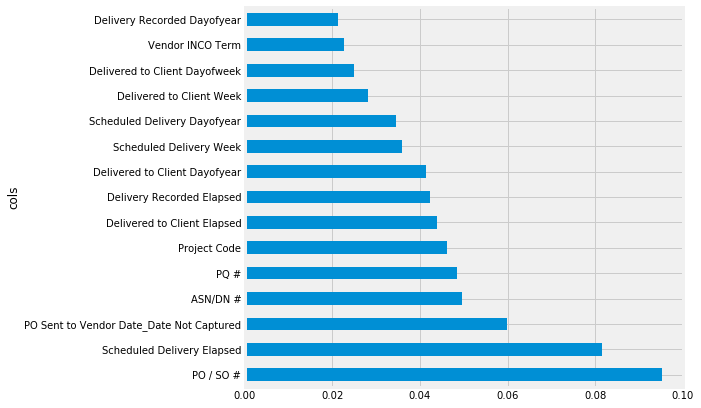

In [37]:
f_imp[:15].plot('cols', 'imp', 'barh', figsize=(7,7), legend=False)

Lets have a look at the top important features and try to draw some inference

In [38]:
predictors = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(predictors[:,0]), np.std(predictors[:,0])

(0.23625, 1.0256697506995125)

lets add this standard deviation to the dataset to check variation of prediction confidence through different trees

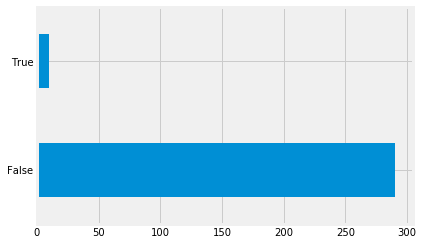

In [39]:
x = raw_valid.copy()
x['pred_std'] = np.std(predictors, axis=0)
x['pred'] = np.mean(predictors, axis=0)
x['PO Sent to Vendor Date_Date Not Captured'].value_counts().plot.barh();

In [40]:
flds = ['PO Sent to Vendor Date_Date Not Captured', 'Delay_in_delivery', 'pred', 'pred_std']
d = x[flds].groupby('PO Sent to Vendor Date_Date Not Captured', as_index=False).mean()
d

,PO Sent to Vendor Date_Date Not Captured,Delay_in_delivery,pred,pred_std
0,False,4.686207,4.788404,9.006468
1,True,65.100000,63.697043,22.347036


the prediction and delay in delivery seems to be pretty close here let's check another feature

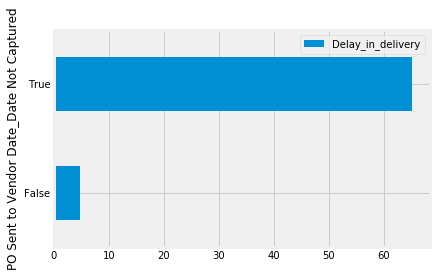

In [41]:
d.plot('PO Sent to Vendor Date_Date Not Captured', 'Delay_in_delivery', 'barh');

so it seems if the date is not captured,it is most likely to be delayed

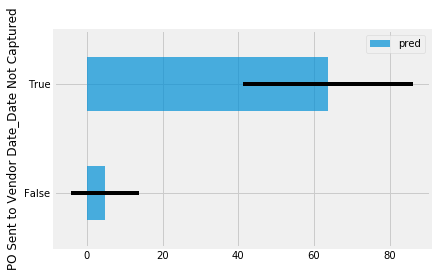

In [42]:
d.plot('PO Sent to Vendor Date_Date Not Captured', 'pred', 'barh', xerr='pred_std', alpha=0.7);

Predictions are nearly right but the error is quite wide,lets further investigate this

In [43]:
# raw_valid['PO / SO #'].unique()

So most of this data is either SCMS or SO (from RDC's).let's investigate this further.lets check whether SCMS or SO from a country for the delay.

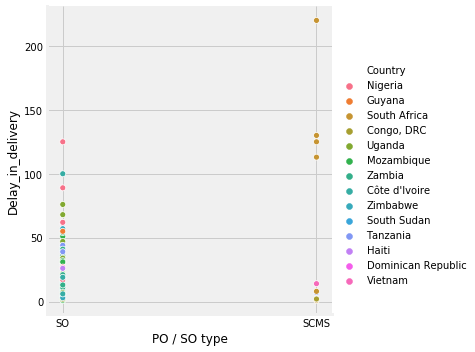

In [44]:
x = raw_valid.copy()
for i,c in x['PO / SO #'].items():
#     print(c)
    x.at[i, 'PO / SO type'] = 'SCMS' if 'SCMS' in c else 'SO'
sns.relplot(x='PO / SO type', y='Delay_in_delivery', hue='Country',data=x[x["Delay_in_delivery"] > 0]);

so it seem's most deliveries dispached from certain SCMS and SO offices to South African Countries may have impact on the delay of delivery.This feature can also be added to dataset for evaluation,simmilarly Dosage, but for now lets continue.

### Removing redundant features

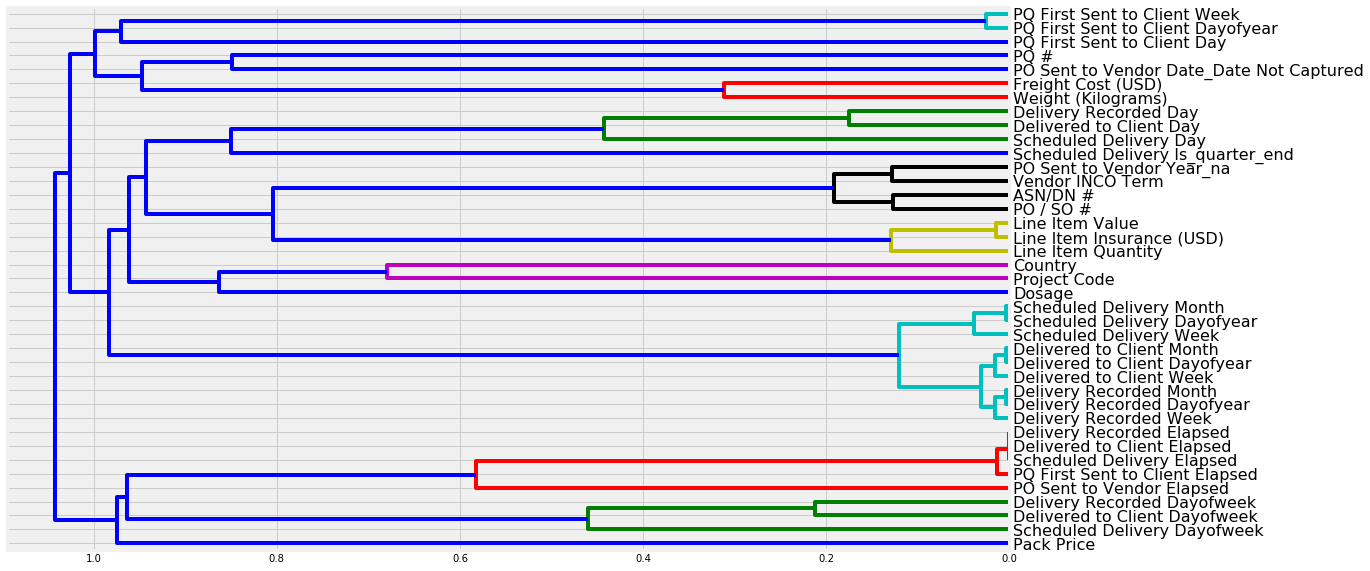

In [45]:
corr = np.round(sc.stats.spearmanr(df_new).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_new.columns, orientation='left', leaf_font_size=16,show_contracted=True)
plt.show()

In [46]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = splitdata(df, n_train)
    m.fit(x, y_train)
    return m.oob_score_

baseline

In [47]:
get_oob(df_new)

0.7478600196221008

From the above Permutaion Importance we see that vendor inco term,freigh cost,etc doesn't affect the model if features are shuffled and from the above dendogram based on spearman correlation which have simmilar meanings.Now based on this inference we can remove each of those variable at a time and check the effect it has on our model.

In [48]:
for c in ('Freight Cost (USD)','Scheduled Delivery Month','Scheduled Delivery Dayofyear','Scheduled Delivery Week',
          'Delivered to Client Week','Delivered to Client Dayofyear','Delivered to Client Month',
          'Delivery Recorded Week','Delivery Recorded Dayofyear','Delivery Recorded Elapsed',
          'Delivered to Client Elapsed','Scheduled Delivery Elapsed'):
    print(c, get_oob(df_new.drop(c, axis=1)))

Freight Cost (USD) 0.7458971440137949
Scheduled Delivery Month 0.7369903282697351
Scheduled Delivery Dayofyear 0.7355968334411864
Scheduled Delivery Week 0.7424326940609667
Delivered to Client Week 0.7438972348987095
Delivered to Client Dayofyear 0.7372309199627071
Delivered to Client Month 0.7486271635732303
Delivery Recorded Week 0.7438395326687435
Delivery Recorded Dayofyear 0.7380853398836753
Delivery Recorded Elapsed 0.7543009725837829
Delivered to Client Elapsed 0.7236143190354768
Scheduled Delivery Elapsed 0.720959375328711


It looks like we can try one from each group for removal. Let's see what that does.

In [49]:
to_drop = ['Freight Cost (USD)','Scheduled Delivery Month',
           'Delivered to Client Week','Delivery Recorded Dayofyear']
get_oob(df_new.drop(to_drop, axis=1))

0.7436175749106428

In [50]:
df_new.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = splitdata(df_new, n_train)

In [51]:
df_rr = df_train[df_new.columns]

In [52]:
forest._generate_sample_indices = (lambda rs, n_samples:forest.check_random_state(rs).randint(0, n_samples, n_samples))

And let's see how this model looks on the full dataset.

In [53]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
score(m)

[8.829357574104353, 9.799381212291141, 0.8893966815508364, 0.8620256153493073, 0.7629209649784018]


### Partial dependence

In [55]:
X_train, X_valid = splitdata(df_train, n_train)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train);

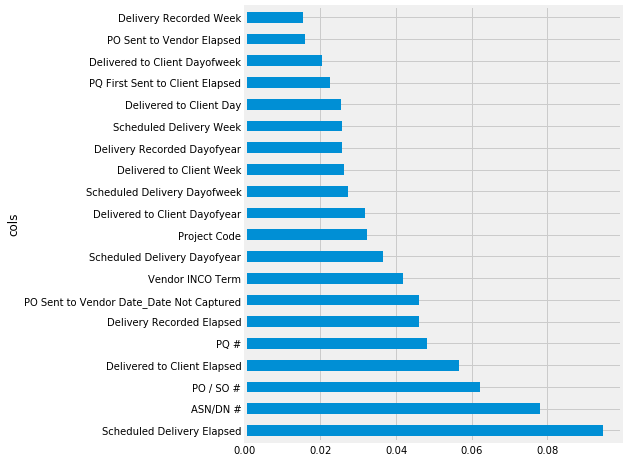

In [56]:
f_imp =  pd.DataFrame({'feats':df_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
f_imp[:20].plot('cols', 'imp', 'barh', figsize=(6,8), legend=False);

From the graph we know that if the PO Sent to Vendor Date not captured is important to our but the question now arsies was delayed from the vendor when the date was not captured? or was due to wrong estimation of scheduled delivery when the date was not captured?,Lets check how each of these features affect our predictions

In [57]:
base_feat = ['Scheduled Delivery Elapsed','Delivered to Client Elapsed','PO Sent to Vendor Elapsed','Delivery Recorded Elapsed']

In [58]:
x=X_train[X_train['PO Sent to Vendor Date_Date Not Captured']==True]

In [59]:
def plot_pdp(feat_name, clusters=None):
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=clusters is not None,n_cluster_centers=clusters)

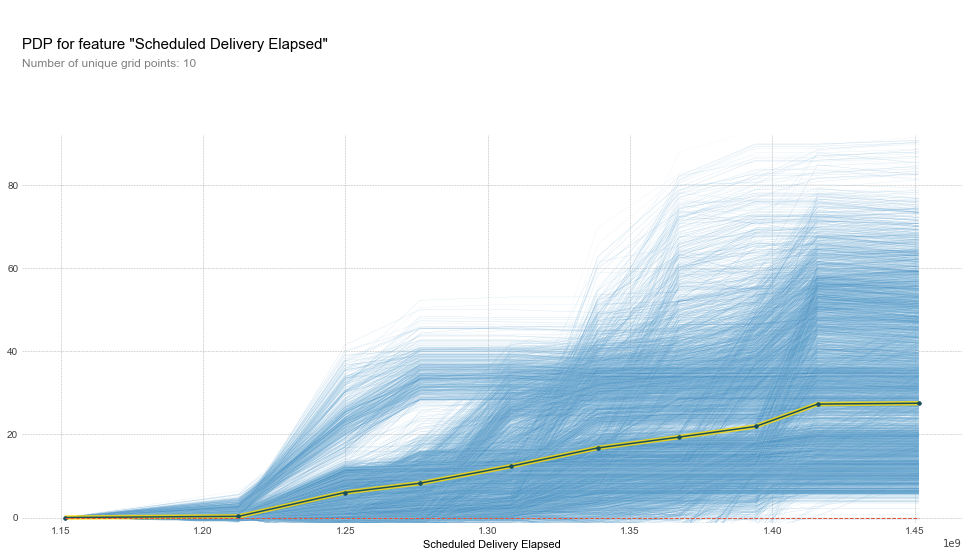

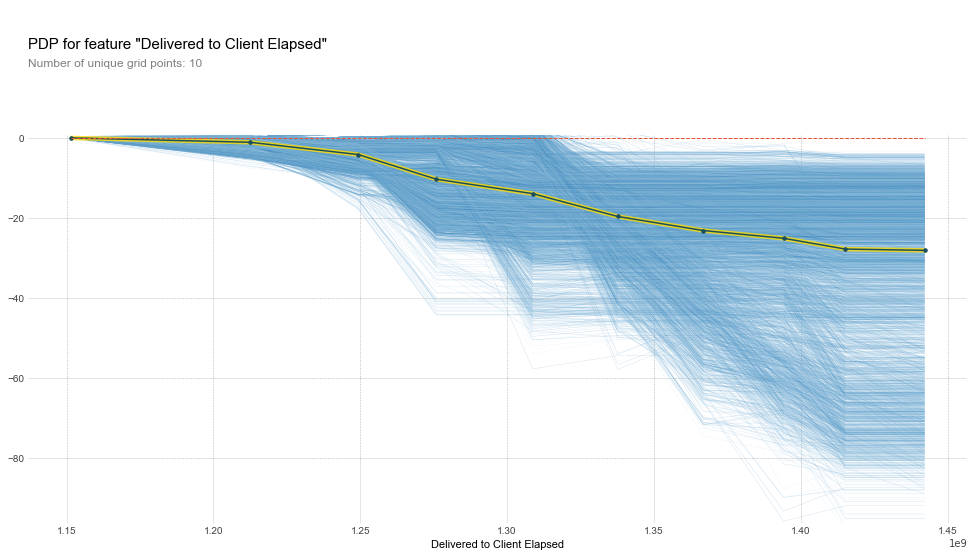

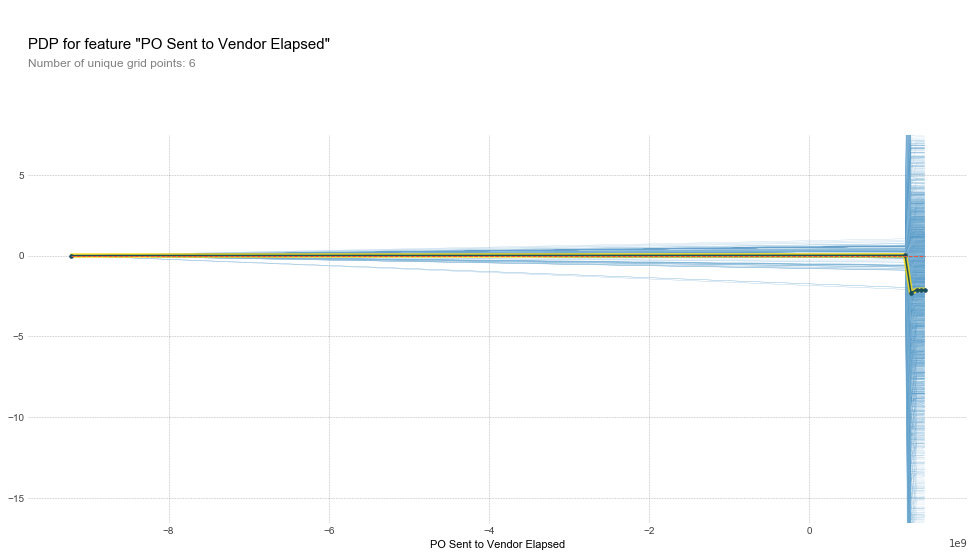

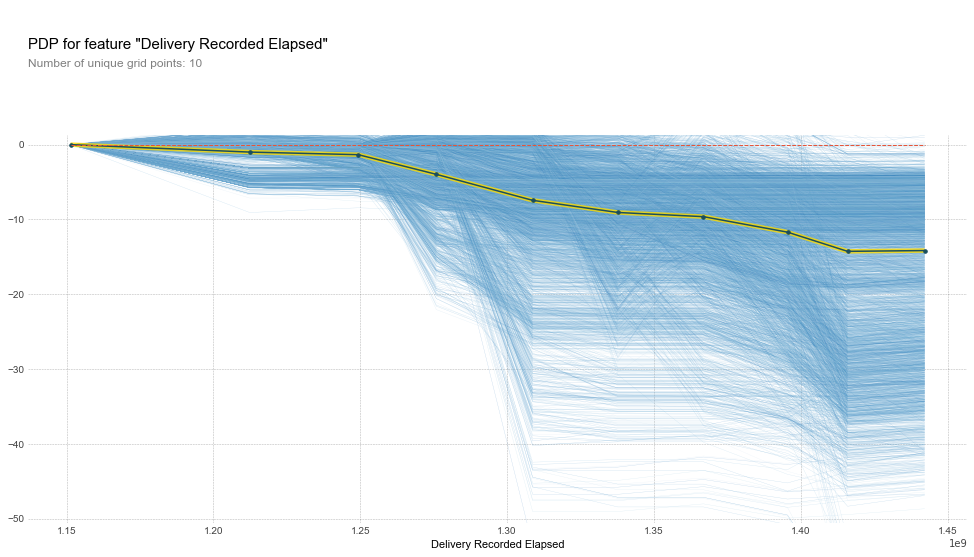

In [60]:
for i in base_feat:
    plot_pdp(i)

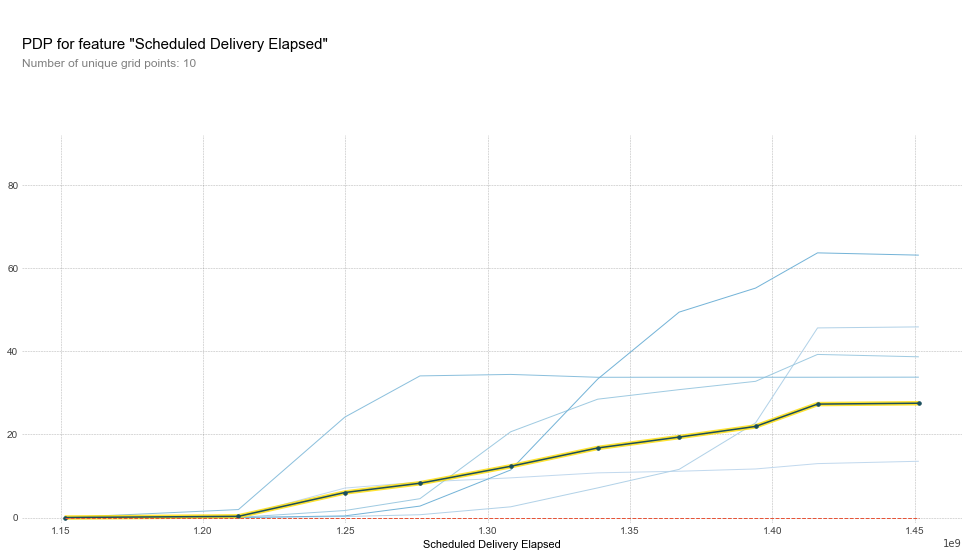

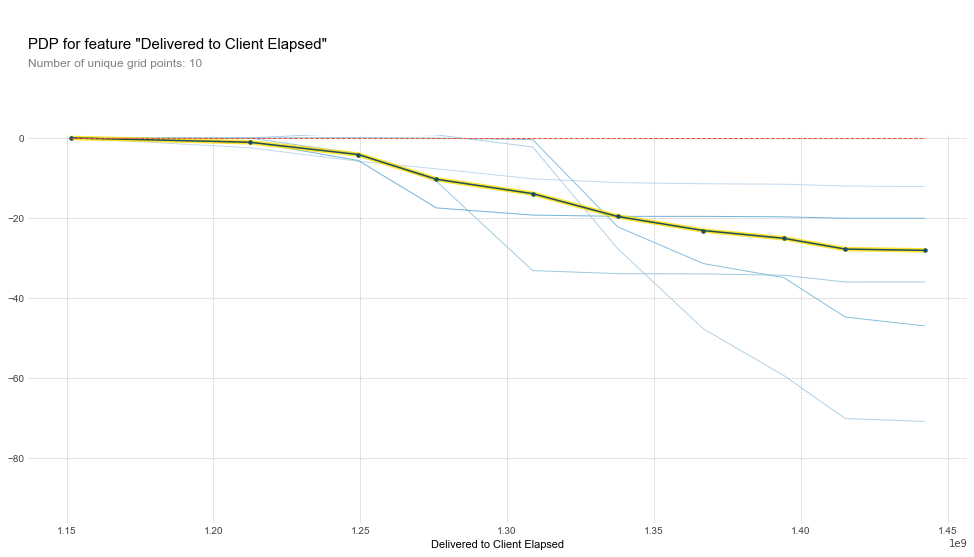

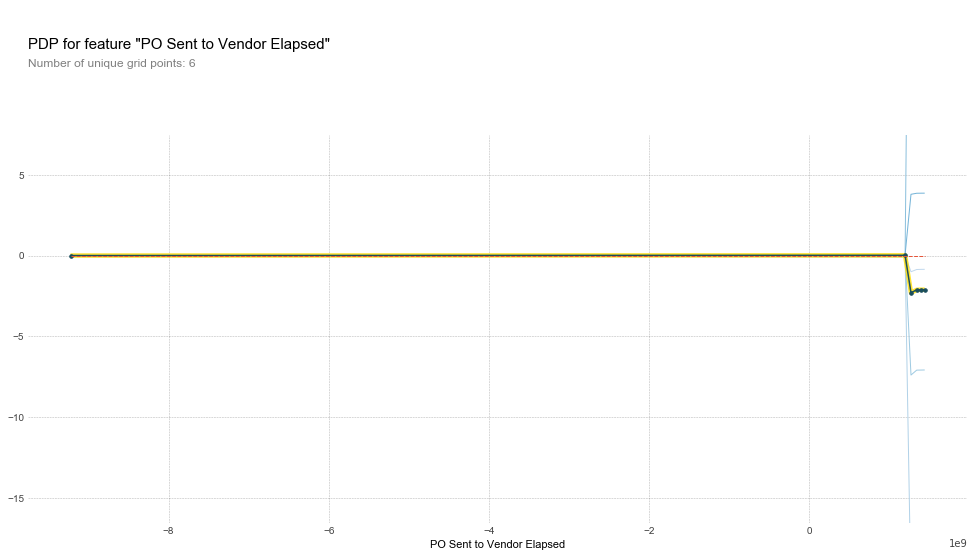

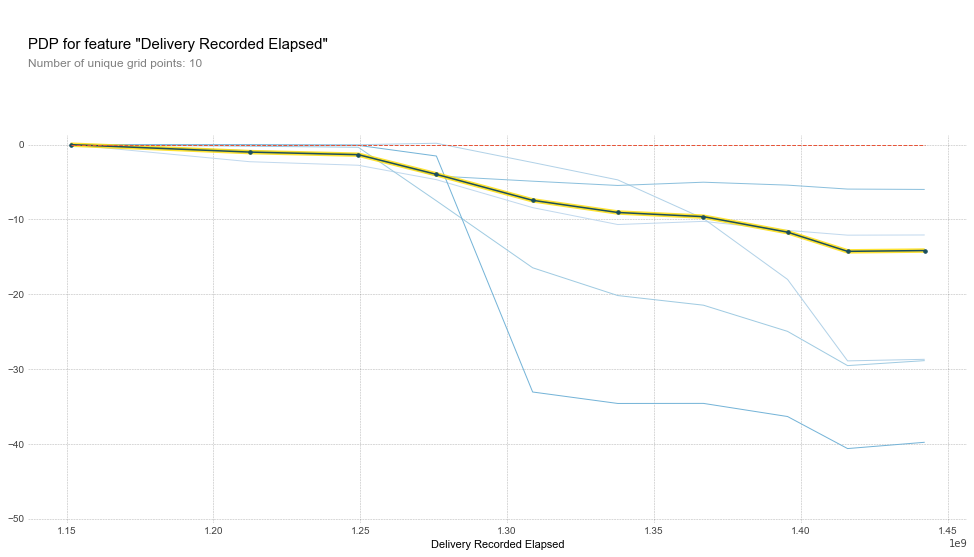

In [61]:
for i in base_feat:
    plot_pdp(feat_name=i,clusters=5)

from this we can see that PO sent to vendor hardly has any effect on the delayed delivery.let's look at the interation between Delivery Client and Recorded Delivery elapsed

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff60a2f8320>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff60ff3ccf8>})

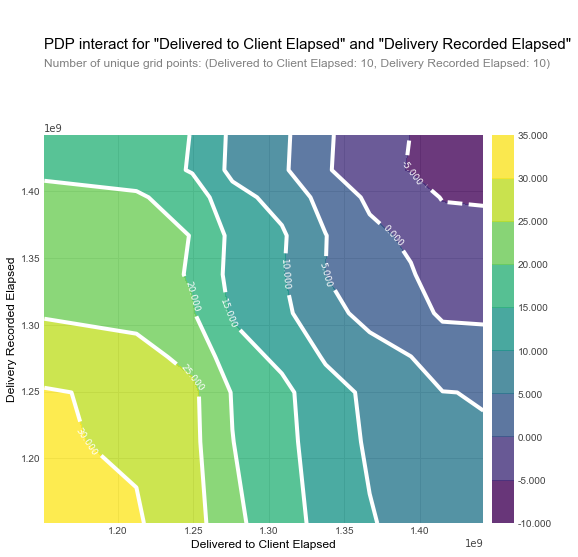

In [62]:
p = pdp.pdp_interact(m, x, features=['Delivered to Client Elapsed','Delivery Recorded Elapsed'], model_features=x.columns)
pdp.pdp_interact_plot(p, ['Delivered to Client Elapsed','Delivery Recorded Elapsed'])

In [63]:
df_rr['abs_delivered_time'] = abs(df_rr['Delivered to Client Elapsed']-df_rr['Delivery Recorded Elapsed'])
df_pdp = df_rr.copy()

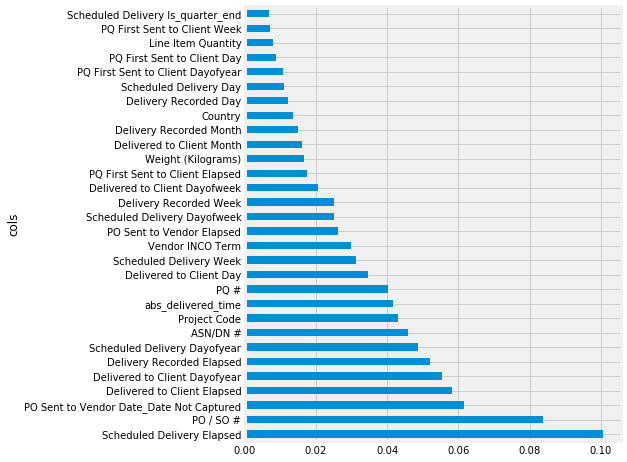

In [64]:
X_train, X_valid = splitdata(df_pdp, n_train)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
f_imp=pd.DataFrame({'feats':df_pdp.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
f_imp[:30].plot('feats', 'imp', 'barh', figsize=(6,8), legend=False);

In [65]:
print_score(m)

[7.434063460918495, 8.950779297597602, 0.9215916210958787, 0.8848874014689502, 0.7961412484885855]


There are still some temporal things we can work with to improve our OOB score but I will be skipping it as of now

### Understanding individual predictions

There are many libraries which use available [shapley additive explanations(SHAP)](https://github.com/slundberg/shap),[Lime](https://github.com/marcotcr/lime),[Skater](https://github.com/oracle/Skater)and [tree interpreter](https://github.com/gregtam/interpreting-decision-trees-and-random-forests) but the more appertain question becomes which one to trust,this is hard to say with certainity,but

lets take an example of a tree where the Root Node divides 50% of instances class 0, 50% class 1,if a feature 'F' <= 50 it goes to the left node and vice versa.The subtree on the left divides 68% instances of class 0 and 42% class 1.The subtree below that on the right divides 99% instances of class 0, 1% instances of class 1.

Now suppose we have an instance with F = 49 that got assigned to the left ( and to class 1). Treeinterpreter won't care if F was really close to ending up on the other side of the equation in the root node, and will assign a low contribution of 0.48 - 0.50 = -0.02 where as SHAP which is based on [shapley values](https://en.wikipedia.org/wiki/Shapley_value),will notice that changing F just a little bit would completely change the odds.

A better way would be to look a the model as whole and think of random instances which may break it but for now let's 
try to interpret this model with SHAP

In [80]:
shap.initjs()
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X_valid)
shap.force_plot(explainer.expected_value, shap_values[2], X_valid.iloc[3,:])

here we are looking a looking at how each feature affects the output value -2.15 of second instance of validation set.

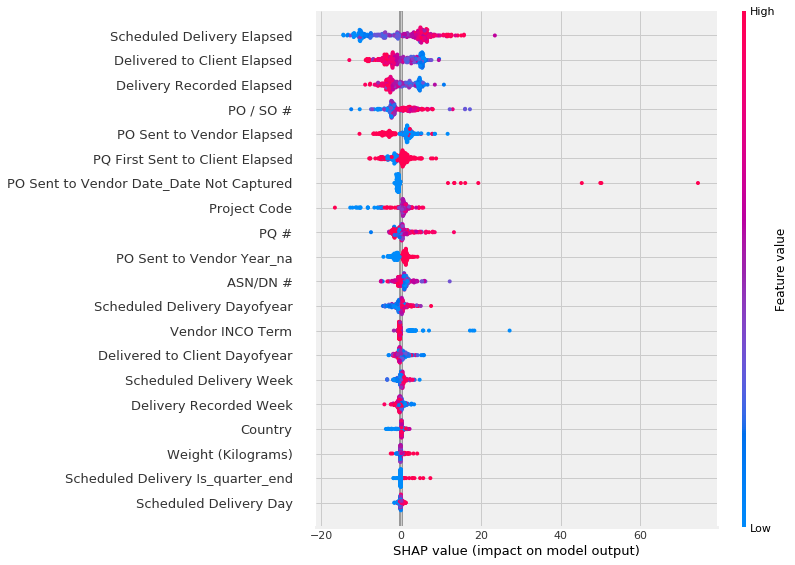

In [87]:
shap.summary_plot(shap_values, X_valid)

here we see that instances ,where PO Sent vendor date was not captured held higher importance

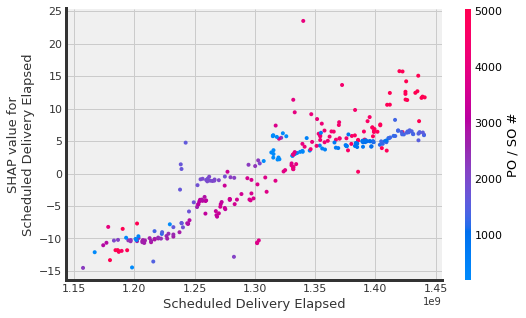

In [96]:
shap.dependence_plot('Scheduled Delivery Elapsed', shap_values, X_valid, interaction_index='PO / SO #')

The purpose of doing this process is to get a better idea of your data and it can further be used for extrapolating a good validation set for building better models.For instance,in the graph above there are several points that lie on the same x axis but have different contribution to the shapley values on Y axis

### Extrapolation and Model Selection

Now that we have a good set of features, it's time to get into the modeling. We already tried one basic model, the Random Forest Classifier which delivered a score of of 0.8 . However,there is no way to know ahead of time which model will work best for a given dataset. . This is from [paper by Randal Olson shows that __there are some problems where even Gaussian Naive Bayes will outperform a gradient boosting machine__](https://psb.stanford.edu/psb-online/proceedings/psb18/olson.pdf)

<img src="algorithm_comparison.png"></img>

therefore,we need try out a number of different models to see which is optimal.There are various machine learning models for regression tasks in [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/multiclass.html). We don't have to try them all, but we can sample from the options which have simmilar methodolgy and try them out.

In addition to the Random Forest Classifier, we'll try LinearSVR,GaussianNB,MLPRegressor,LogisticRegressionCV, RidgeClassifierCV,LinearDiscriminantAnalysis,KNeighborsClassifier. We will make a dataframe to hold the results and compare them.

In [98]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings 
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

model_results = pd.DataFrame(columns = ['model', 'pred_mean', 'pred_std'])

def Predict_model(X, Y, model, name, model_results=None):
    
    pred = model.fit(X,Y)
    print(f'pred score: {round(pred.score(), 5)} with std: {round(pred.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name,'pred_mean': pred.score(),
                                                           'pred_std': pred.std()},index = [0]),
                                                            ignore_index = True)
        return model_results

In [2]:
model_results = Predict_model(X_train,y_train, LinearSVR(), 
                         'LSVR', model_results)

NameError: name 'Predict_model' is not defined

In [ ]:
model_results = Predict_model(X_train,y_train,
                         GaussianNB(), 'GNB', model_results)

In [ ]:
model_results = Predict_model(X_train,y_train, MLPRegressor(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                              'MLP', model_results)

In [ ]:
model_results = Predict_model(X_train,y_train, LinearDiscriminantAnalysis(), 'LDA', model_results)

In [ ]:
model_results = Predict_model(X_train,y_train, Ridge(),'RIDGE', model_results)

In [ ]:
model_results = Predict_model(X_train,y_train, ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                              'EXT', model_results)

With the modeling results in a dataframe, we can plot them to see which model does the best.

In [ ]:
model_results = cv_model(X_train,y_train, RandomForestRegressor(n_estimators=100,n_jobs=-1),'RF', model_results)

model_results.set_index('model', inplace = True)
model_results['pred_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['pred_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model Score Results');
plt.ylabel('MeanScore (with error bar)');
model_results.reset_index(inplace = True)

Ideally we should try different combinations of hyperparameters for every model, but we will ignore it for the time being. The graph below shows the effect of hyperparameter tuning versus the default values in Scikit-Learn.

<img src= 'hyperparameter_improvement.png'></img>
 

### Summary

The purpose of this notebook was to demonstrate a general practice that I follow in evaluating and developing real-world  machine learning models.Data science, in general is not about getting the best statistical accuracy possible.It is more about getting the best performance in resolving a problem by constantly acessing and improving our past decisions.

Although RMSE,R-squared are good statistical indicators they might not be the best ones for our problem.

These are the general steps that I follow:
1. Understand the problem - classification, regression, clustering
2. Build a basic model with some basic feature engineering-
    * Fill in/Replace missing values,adding date features. 
    * I usually start wih Random Forest model because it assumes each feature has equal importance to begin with.
3. Permutation Importance and Removing Redundant Feature
    * Once you have build a base model you can remove some features based on the feature importance and redundancy.
4. Interpreting Individual Predictions and Exploratory Data Analysis
    * Use Model Iterpretaion techniques to understand prediction and build new features
    * validation set selection can also come into play    
5. Model Selection and Optimization
    * Finetune hyperparameters and compare different models
6. Implement the best model
7. Experiment and Repeat.
   *  Investigate predictions in context of problem and Identify the shortcomings
    

Thanks for reading.There are a lot things I missed like dealing with covariate shift,looking for data leakage,hyperparmeter tuning ,etc. but the general guidelines remain the same.The best part about data science is you keep improving by sharing your work.If you have different insights or any qualms please feel free to raise an issue or share it with me